In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [29]:
img_size=2000
np.random.seed(1234567)
#loading data and fitting follows:
X_train=np.loadtxt('training_data/Xtrain_av_clean.csv',delimiter=',')
Y_train=np.loadtxt('training_data/Ytrain_av_clean.csv',delimiter=',')
#Xtrain=Xtrain[:2000]
#X_train=np.transpose(X_train)
print(X_train.shape,Y_train.shape)


(3578, 2000) (3578, 2)


In [72]:
kernel_size = 3
kernel = np.ones(kernel_size) / kernel_size
X_train = np.array([np.convolve(X_train[i], kernel, mode='same') for i in range(len(X_train))])
#X_test = [np.convolve(Xtest[i], kernel, mode='same') for i in range(len(Xtest))]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_train, Y_train, test_size=0.1)
print(Xtrain.shape,Xtest.shape)

(3220, 2000) (358, 2000)


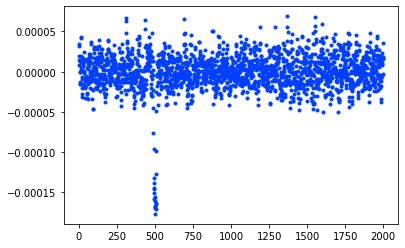

In [31]:
plt.plot(Xtrain[686],marker='.',ls="none")
#print([el[np.argmin(el)] for el in Xtrain])

In [65]:
#defining a sampling function: returns a random sample from a mean and variance
#that is input to it

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = keras.backend.random_normal(shape=keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + keras.backend.exp(log_variance/2) * epsilon
    return random_sample

In [67]:
from keras import backend as K
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 100
        reconstruction_loss = keras.backend.mean(keras.backend.square(y_true-y_predict), axis=[1, 2])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * keras.backend.sum(1.0 + encoder_log_variance - keras.backend.square(encoder_mu) - keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * keras.backend.sum(1.0 + encoder_log_variance - keras.backend.square(encoder_mu) - keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [68]:
#model defined here
#leaky reLU has been added as a separate layer than define as an activation
inp = keras.layers.Input(shape=(img_size, 1), name="encoder_input")
x1 = keras.layers.Conv1D(filters=1, kernel_size=3, padding="same", strides=1,name="encoder_conv_1", activation="tanh")(inp)
x1 = keras.layers.BatchNormalization(name="encoder_norm_1")(x1)
#x1 = keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(x1)

x1 = keras.layers.Conv1D(filters=16, kernel_size=3, padding="same", strides=2, name="encoder_conv_2",activation="tanh")(x1)
x1 = keras.layers.BatchNormalization(name="encoder_norm_2")(x1)
#x1 = keras.layers.LeakyReLU(name="encoder_leakyrelu_2")(x1)

x1 = keras.layers.Conv1D(filters=32, kernel_size=5, padding="same", strides=2, name="encoder_conv_3", activation="tanh")(x1)
x1 = keras.layers.BatchNormalization(name="encoder_norm_3")(x1)
#x1 = keras.layers.LeakyReLU(name="encoder_leakyrelu_3")(x1)

x1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", strides=1, name="encoder_conv_4", activation="tanh")(x1)
bp_lay_1 = keras.layers.BatchNormalization(name="encoder_norm_4")(x1)
#bp_lay_1 = keras.layers.LeakyReLU(name="encoder_leakyrelu_4")(x1)

#flatten the layers in encoder
shape_before_flatten = keras.backend.int_shape(bp_lay_1)[1:]
aft_flat = keras.layers.Flatten(name="flat_1")(bp_lay_1)

latent_space_dim = 8
#declare a mean and variance for the distribution
encoder_mu = keras.layers.Dense(units=latent_space_dim, name="encoder_mu",activity_regularizer=keras.regularizers.l1(10e-5))(aft_flat)
encoder_log_variance = keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(aft_flat)
encoder_op = keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = keras.models.Model(inp, aft_flat, name="encoder_model")
encoder.summary()


Model: "encoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 2000, 1)]         0         
_________________________________________________________________
encoder_conv_1 (Conv1D)      (None, 2000, 1)           4         
_________________________________________________________________
encoder_norm_1 (BatchNormali (None, 2000, 1)           4         
_________________________________________________________________
encoder_conv_2 (Conv1D)      (None, 1000, 16)          64        
_________________________________________________________________
encoder_norm_2 (BatchNormali (None, 1000, 16)          64        
_________________________________________________________________
encoder_conv_3 (Conv1D)      (None, 500, 32)           2592      
_________________________________________________________________
encoder_norm_3 (BatchNormali (None, 500, 32)         

In [69]:
#decoder_input = keras.layers.Input(shape=(shape_before_flatten), name="decoder_input")
#decoder_input = keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
x3 = keras.layers.Dense(units=np.prod(shape_before_flatten), activation="tanh",name="decoder_dense_1")(encoder_op)
x3 = keras.layers.Reshape(target_shape=shape_before_flatten)(x3)

x3 = keras.layers.Conv1DTranspose(filters=64, kernel_size=3, padding="same", strides=1, activation="tanh", name="decoder_conv_tran_1")(x3)
x3 = keras.layers.BatchNormalization(name="decoder_norm_1")(x3)
#x3 = keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(x3)

x3 = keras.layers.Conv1DTranspose(filters=32, kernel_size=3, padding="same", strides=2, activation="tanh",name="decoder_conv_tran_2")(x3)
x3 = keras.layers.BatchNormalization(name="decoder_norm_2")(x3)
x3 = keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(x3)

x3 = keras.layers.Conv1DTranspose(filters=16, kernel_size=3, padding="same", strides=2, activation="tanh", name="decoder_conv_tran_3")(x3)
x3 = keras.layers.BatchNormalization(name="decoder_norm_3")(x3)
x3 = keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(x3)

decoder_output = keras.layers.Conv1DTranspose(filters=1, kernel_size=3, padding="same", strides=1,activation='tanh', name="decoder_op_layer")(x3)
#decoder_output = keras.layers.LeakyReLU(name="decoder_output")(x3)

#decoder = keras.models.Model(decoder_input, decoder_output, name="decoder_model")
#decoder.summary()


In [70]:
x3 = keras.layers.concatenate([encoder_mu, encoder_log_variance],name='combine_layer')
x3 = keras.layers.Dense(16, activation='tanh',name='class_lay_1')(x3)
x3 = keras.layers.Dense(8, activation='tanh',name='class_lay_2')(x3)
class_out = keras.layers.Dense(2, activation='sigmoid',name='class_op_layer')(x3)


In [71]:
#model for the vae
#vae_input = keras.layers.Input(shape=(img_size,1), name="VAE_input")
#vae_encoder_output = encoder(vae_input)
#vae_decoder_output = decoder(vae_encoder_output)
#vae = keras.models.Model(vae_input, vae_decoder_output, name="VAE")

#vae.summary()
#vae.compile(optimizer=keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())
#vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

full_model = keras.models.Model(inp,outputs=[decoder_output,class_out], name="classifier")

full_model.summary()

full_model.compile(loss={'class_op_layer': 'categorical_crossentropy', 'decoder_op_layer': loss_func(encoder_mu, encoder_log_variance)},
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              metrics={'class_op_layer': 'accuracy'})
#full_model.compile(loss={'class_op_layer': 'categorical_crossentropy', 'decoder_op_layer': 'mean_squared_error'},
#            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
#            metrics={'class_op_layer': 'accuracy'})


Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 2000, 1)]    0                                            
__________________________________________________________________________________________________
encoder_conv_1 (Conv1D)         (None, 2000, 1)      4           encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_norm_1 (BatchNormalizat (None, 2000, 1)      4           encoder_conv_1[0][0]             
__________________________________________________________________________________________________
encoder_conv_2 (Conv1D)         (None, 1000, 16)     64          encoder_norm_1[0][0]             
_________________________________________________________________________________________

In [73]:
#Xtrain_N=[]
#[Xtrain_N.append(Xtrain[i]/np.abs(Xtrain[i][np.argmin(Xtrain[i])])) for i in range(0,3231)]
#Xtrain=np.array(Xtrain_N).reshape(3231,12000,1)
#arr=np.arange(0,4500,1)
#np.random.shuffle(arr)
#Xtrain=np.array([Xtrain[i] for i in arr])
#Xtrain=np.array(Xtrain).reshape(4500,2000,1)
#Xtrain=Xtrain[0:4500]
print(np.array(Xtrain).shape)
#scaler = preprocessing.StandardScaler().fit(Xtrain)
#X_scaled = scaler.transform(Xtrain)
#Xtrain=[preprocessing.normalize(Xtrain[i]) for i in range(0,len(Xtrain))]
Xtrain=preprocessing.normalize(Xtrain)
Xtrain=np.array(Xtrain).reshape(3220, img_size, 1)
print(np.array(Xtrain).shape)
#Xtrain=np.array(Xtrain)

(3220, 2000)
(3220, 2000, 1)


In [84]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
#history=vae.fit(Xtrain, Xtrain, epochs=20, batch_size=64 ,verbose=1, validation_split=0.3)
history=full_model.fit(Xtrain, [Xtrain, Ytrain], epochs=50, batch_size=64 ,verbose=1,shuffle=True, validation_split=0.2)

Epoch 1/50
41/41 [==============================] - 20s 487ms/step - loss: 1.0870 - decoder_op_layer_loss: 0.6477 - class_op_layer_loss: 0.4351 - class_op_layer_accuracy: 0.8098 - val_loss: 1.6241 - val_decoder_op_layer_loss: 0.7617 - val_class_op_layer_loss: 0.8583 - val_class_op_layer_accuracy: 0.6848
Epoch 2/50
41/41 [==============================] - 20s 481ms/step - loss: 0.8406 - decoder_op_layer_loss: 0.5878 - class_op_layer_loss: 0.2483 - class_op_layer_accuracy: 0.9049 - val_loss: 1.3588 - val_decoder_op_layer_loss: 0.6782 - val_class_op_layer_loss: 0.6765 - val_class_op_layer_accuracy: 0.7096
Epoch 3/50
41/41 [==============================] - 20s 487ms/step - loss: 0.7734 - decoder_op_layer_loss: 0.5761 - class_op_layer_loss: 0.1928 - class_op_layer_accuracy: 0.9309 - val_loss: 1.3209 - val_decoder_op_layer_loss: 0.6417 - val_class_op_layer_loss: 0.6750 - val_class_op_layer_accuracy: 0.7050
Epoch 4/50
41/41 [==============================] - 20s 491ms/step - loss: 0.7315 - d

In [62]:
vae.save_weights('autoencoder_raw_7936_d8.h5')
encoder.save_weights('encoding_raw_7936_d8.h5')
decoder.save_weights('decoding_raw_7936_d8.h5')

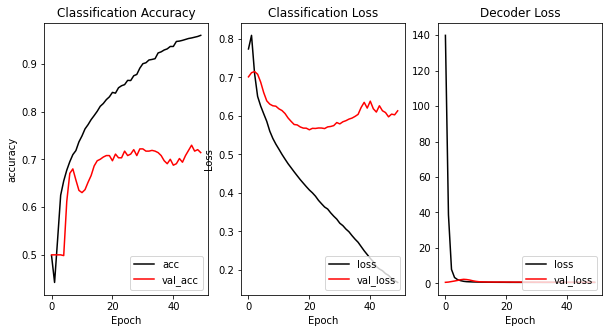

In [75]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,3,figsize=(10,5))
plt.style.use("seaborn-bright")

ax[0].plot(history.history['class_op_layer_accuracy'], label='acc',color="black")
ax[0].plot(history.history['val_class_op_layer_accuracy'], label = 'val_acc',color="red")
ax[1].plot(history.history['class_op_layer_loss'], label='loss',color="black")
ax[1].plot(history.history['val_class_op_layer_loss'], label = 'val_loss',color="red")
ax[2].plot(history.history['decoder_op_layer_loss'], label='loss',color="black")
ax[2].plot(history.history['val_decoder_op_layer_loss'], label = 'val_loss',color="red")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[2].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[0].set_title('Classification Accuracy')
ax[1].set_title('Classification Loss')
ax[2].set_title('Decoder Loss')
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
ax[2].legend(loc='lower right')
#plt.savefig('VAE_loss.png')
plt.show()

In [85]:
from sklearn.metrics import classification_report, confusion_matrix
#Xtest=np.array(Xtrain).reshape(1138, 7936, 1)
#Xtest=preprocessing.normalize(Xtest)
Xtest=np.array(Xtest).reshape(358, 2000, 1)
test_loss,dec_test_loss,class_test_loss,test_acc = full_model.evaluate(np.array(Xtrain),[np.array(Xtrain),np.array(Ytrain)])
print('Test accuracy:', test_acc)
Y_pred1,Y_pred2=full_model.predict(np.array(Xtrain))
Ypred=np.argmax(Y_pred2, axis=1)
Ytest_new=np.argmax(Ytrain,axis=1)
cm = confusion_matrix(Ytest_new, Ypred)
print(cm)

101/101 [==============================] - 10s 68ms/step - loss: 0.7501 - decoder_op_layer_loss: 0.5586 - class_op_layer_loss: 0.1869 - class_op_layer_accuracy: 0.9413
Test accuracy: 0.9413043260574341
[[1374  109]
 [  80 1657]]


In [81]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
#history=vae.fit(Xtrain, Xtrain, epochs=20, batch_size=64 ,verbose=1, validation_split=0.3)
history=full_model.fit(Y_pred1,  [Xtrain, Ytrain], epochs=30, batch_size=64 ,verbose=1,shuffle=True, validation_split=0.2)

Epoch 1/30
41/41 [==============================] - 21s 506ms/step - loss: 0.7824 - decoder_op_layer_loss: 0.5574 - class_op_layer_loss: 0.2196 - class_op_layer_accuracy: 0.9270 - val_loss: 1.5210 - val_decoder_op_layer_loss: 0.6892 - val_class_op_layer_loss: 0.8270 - val_class_op_layer_accuracy: 0.6537
Epoch 2/30
41/41 [==============================] - 20s 485ms/step - loss: 0.7788 - decoder_op_layer_loss: 0.5566 - class_op_layer_loss: 0.2168 - class_op_layer_accuracy: 0.9270 - val_loss: 1.6088 - val_decoder_op_layer_loss: 0.7924 - val_class_op_layer_loss: 0.8117 - val_class_op_layer_accuracy: 0.6584
Epoch 3/30
41/41 [==============================] - 20s 489ms/step - loss: 0.7734 - decoder_op_layer_loss: 0.5561 - class_op_layer_loss: 0.2119 - class_op_layer_accuracy: 0.9247 - val_loss: 1.5335 - val_decoder_op_layer_loss: 0.6962 - val_class_op_layer_loss: 0.8326 - val_class_op_layer_accuracy: 0.6522
Epoch 4/30
41/41 [==============================] - 20s 492ms/step - loss: 0.7777 - d

In [86]:
test_loss,dec_test_loss,class_test_loss,test_acc = full_model.evaluate(np.array(Xtrain),[np.array(Xtrain),np.array(Ytrain)])
print('Test accuracy:', test_acc)
Y_pred1_next,Y_pred2_next=full_model.predict(np.array(Xtrain))
Ypred=np.argmax(Y_pred2_next, axis=1)
Ytest_new=np.argmax(Ytrain,axis=1)
cm = confusion_matrix(Ytest_new, Ypred)
print(cm)

101/101 [==============================] - 9s 85ms/step - loss: 0.7507 - decoder_op_layer_loss: 0.5592 - class_op_layer_loss: 0.1869 - class_op_layer_accuracy: 0.9413
Test accuracy: 0.9413043260574341
[[1374  109]
 [  80 1657]]


Text(0.5, 0, 'Phase')

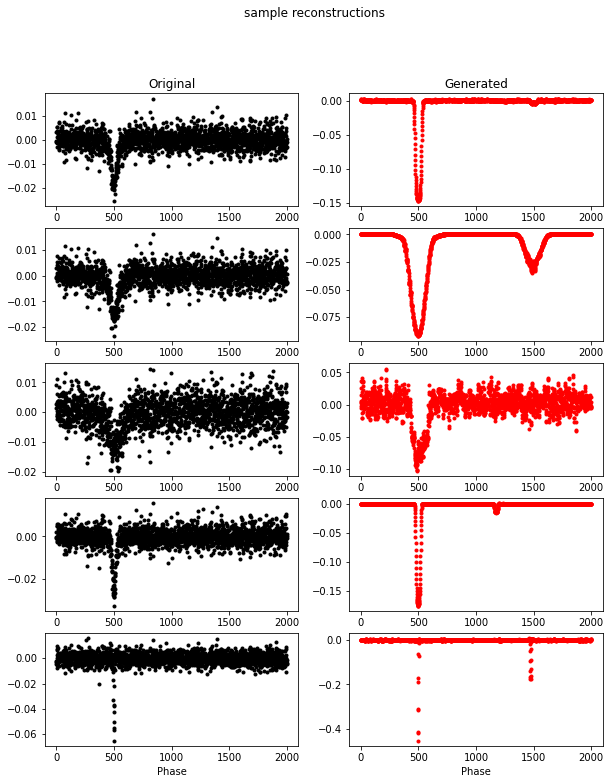

In [87]:
fig,ax=plt.subplots(5,2,figsize=(10,12))
plt.style.use('seaborn-bright')
plt.suptitle('sample reconstructions')
ar=[119,2203,627,254,820]
ax[0][0].set_title('Original')
ax[0][1].set_title('Generated')
for i in range(0,5):
    ax[i][0].plot(Y_pred1[ar[i]],color='black',ls='None',marker='.')
    ax[i][1].plot(Xtrain[ar[i]],color='red',ls='None',marker='.')
ax[4][0].set_xlabel('Phase')
ax[4][1].set_xlabel('Phase')
#plt.savefig('sample_reconstructions.png')
#ax[1].set_ylim(0,0.04)
#ax[1].set_xlim(250,300)